In [43]:
import os
from collections import defaultdict
from functools import partial

import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import scipy.stats
import torch
import torch.distributions.constraints as constraints
from matplotlib import pyplot
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.poutine import block, replay, trace

In [44]:
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values
goal = mobility[np.logical_and(mobility>0.2, mobility<0.75)]
goalFreq = freq[np.logical_and(mobility>0.2, mobility<0.75)]
goal = torch.tensor(goal)
goalFreq = torch.tensor(goalFreq)

In [45]:
def model(data):
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    z = pyro.sample('z', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([0.1])

    with pyro.plate('data', len(data)):
        pyro.sample('x', dist.Normal(z*z, scale), obs=data)

def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([0.0]))
    pyro.sample("z", dist.Normal(loc_q, scale_q))

In [68]:

goalFreq = freq[np.logical_and(mobility>0.2, mobility<0.75)]
def model(data):
    E_loc = torch.tensor([0.])
    E_scale = torch.tensor([1.])
    E = pyro.sample('E', dist.Normal(E_loc, E_scale))
    rho_loc = torch.tensor([0.])
    rho_scale = torch.tensor([1.])
    rho = pyro.sample('rho', dist.Normal(rho_loc, rho_scale))
    eta_loc = torch.tensor([0.])
    eta_scale = torch.tensor([1.])
    eta = pyro.sample('eta', dist.Normal(eta_loc, eta_scale))
    scale = torch.tensor([0.1])

    mobility = mobCalc(E.clone().detach().numpy(),rho.clone().detach().numpy(),eta.clone().detach().numpy())
    with pyro.plate('data', len(data)):
        pyro.sample('x', dist.Normal(mobility, scale), obs=data)

def guide(data, index):
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([0.0]))
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([0.01]))
    pyro.sample("E", dist.Normal(loc_q, scale_q))

def normalization(E, rho, eta):
    E_theo=9.7e10
    E_var_init =5.0e9
    rho_theo=8000.0
    rho_var_init =250.0
    eta_mean=0.00505
    eta_var_init = 0.006
    
    rho_norm = rho*rho_var_init + rho_theo
    eta_norm = eta*eta_var_init + eta_mean
    E_norm = E*E_var_init + E_theo

    return rho_norm, eta_norm, E_norm

def mobCalc(E_dist, rho_dist, eta_dist):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    global goalFreq
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12

    E,rho, eta = normalization(E_dist, rho_dist, eta_dist)
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*np.pi*goalFreq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = np.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*np.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return torch.tensor(abs(Y))

In [69]:
def relbo(model, guide, *args, **kwargs):
    approximation = kwargs.pop('approximation')

    # We first compute the elbo, but record a guide trace for use below.
    traced_guide = trace(guide)
    elbo = pyro.infer.Trace_ELBO(max_plate_nesting=1)
    loss_fn = elbo.differentiable_loss(model, traced_guide, *args, **kwargs)

    # We do not want to update parameters of previously fitted components
    # and thus block all parameters in the approximation apart from z.
    guide_trace = traced_guide.trace
    replayed_approximation = trace(replay(block(approximation, expose=['z']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)

    relbo = -loss_fn - approximation_trace.log_prob_sum()

    # By convention, the negative (R)ELBO is returned.
    return -relbo

In [70]:
def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result

In [71]:
initial_approximation = partial(guide, index=0)
components = [initial_approximation]
weights = torch.tensor([1.])
wrapped_approximation = partial(approximation, components=components, weights=weights)

In [72]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Sample observations from a Normal distribution with loc 4 and scale 0.1
n = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([0.1]))
data = n.sample((100,))
data = goal
#T=2
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 3000
pyro.set_rng_seed(2)
n_iterations = 1
locs = [0]
scales = [0]
for t in range(1, n_iterations + 1):

    # Create guide that only takes data as argument
    wrapped_guide = partial(guide, index=t)
    losses = []

    adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    adam_params = {
        "lr": .01, #0.001,
        "betas": (0.96, 0.999),
        "clip_norm": 20.0,
        "lrd": 0.99996,
        "weight_decay": 2.0}
    optimizer = ClippedAdam(adam_params)
    # Pass our custom RELBO to SVI as the loss function.
    svi = SVI(model, wrapped_guide, optimizer, loss=relbo)
    for step in range(n_steps):
        # Pass the existing approximation to SVI.
        loss = svi.step(data, approximation=wrapped_approximation)
        losses.append(loss)

        if step % 100 == 0:
            print('.', end=' ')

    # Update the list of approximation components.
    components.append(wrapped_guide)

    # Set new mixture weight.
    new_weight = 2 / (t + 1)

    # In this specific case, we set the mixture weight of the second component to 0.5.
    if t == 2:
        new_weight = 0.5
    weights = weights * (1-new_weight)
    weights = torch.cat((weights, torch.tensor([new_weight])))

    # Update the approximation
    wrapped_approximation = partial(approximation, components=components, weights=weights)

    print('Parameters of component {}:'.format(t))
    scale = pyro.param("scale_{}".format(t)).item()
    scales.append(scale)
    loc = pyro.param("loc_{}".format(t)).item()
    locs.append(loc)
    print('loc = {}'.format(loc))
    print('scale = {}'.format(scale))

/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_45344/2302347390.py:72: RuntimeWarning: overflow encountered in cos
  N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_45344/2302347390.py:72: RuntimeWarning: invalid value encountered in multiply
  N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_45344/2302347390.py:73: RuntimeWarning: overflow encountered in cos
  D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)
/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_45344/2302347390.py:73: RuntimeWarning: invalid value encountered in multiply
  D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)
/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_45344/2302347390.py:73: RuntimeWarning: overflow encountered in sin
  D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)

ValueError: Expected parameter loc (Tensor of shape (32,)) of distribution Normal(loc: torch.Size([32]), scale: torch.Size([32])) to satisfy the constraint Real(), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], dtype=torch.float64)
Trace Shapes:     
 Param Sites:     
Sample Sites:     
       E dist  1 |
        value  1 |
     rho dist  1 |
        value  1 |
     eta dist  1 |
        value  1 |
    data dist    |
        value 32 |

<AxesSubplot:ylabel='Density'>

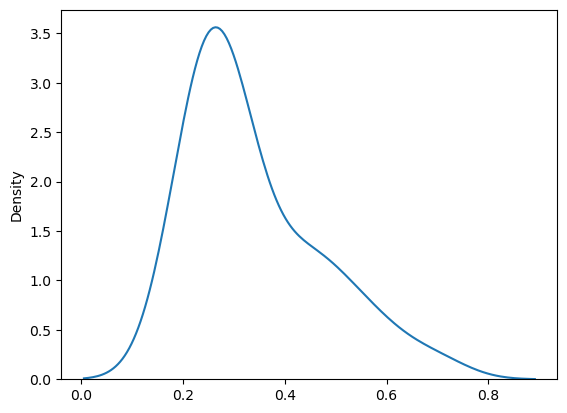

In [59]:
import seaborn as sns
sns.kdeplot(data)

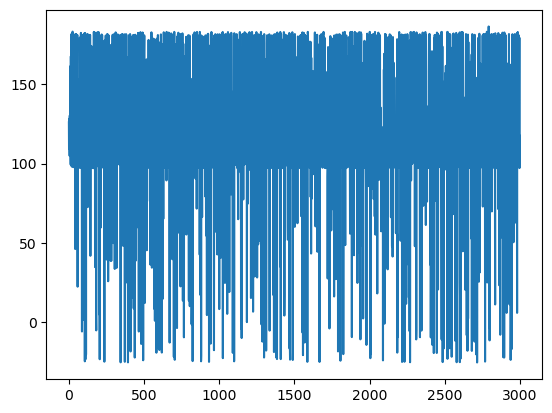

In [60]:
import matplotlib.pyplot as plt
plt.plot(losses)

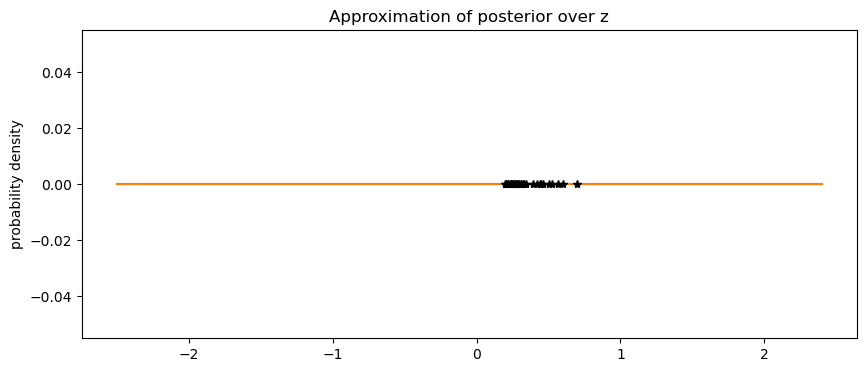

In [61]:
X = np.arange(-2.5, 2.5, 0.1)
pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
total_approximation = np.zeros(X.shape)
for i in range(1, n_iterations + 1):
    Y = weights[i].item() * scipy.stats.norm.pdf((X - locs[i]) / scales[i])
    pyplot.plot(X, Y)
    total_approximation += Y
pyplot.plot(X, total_approximation)
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Approximation of posterior over z')
pyplot.ylabel('probability density')
pyplot.show()

<AxesSubplot:ylabel='Density'>

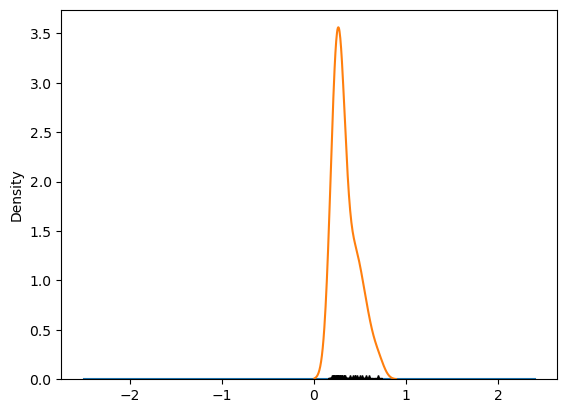

In [62]:

pyplot.plot(X, total_approximation)
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
sns.kdeplot(data.data.numpy())

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 1:
loc = -1.9996534585952759
scale = 0.016739774495363235
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 2:
loc = 1.9982420206069946
scale = 0.01308442372828722


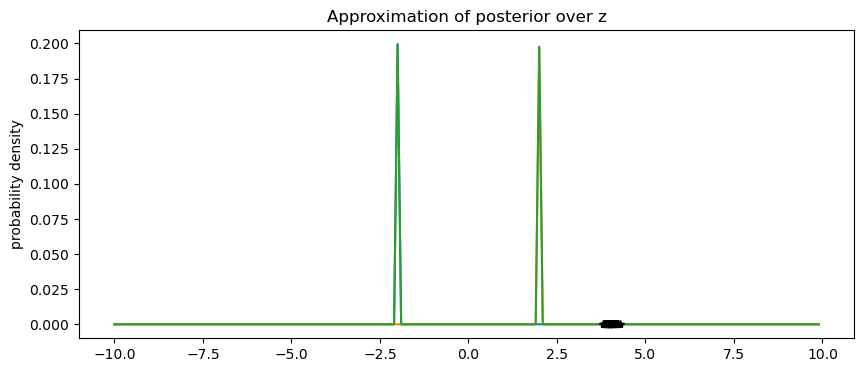

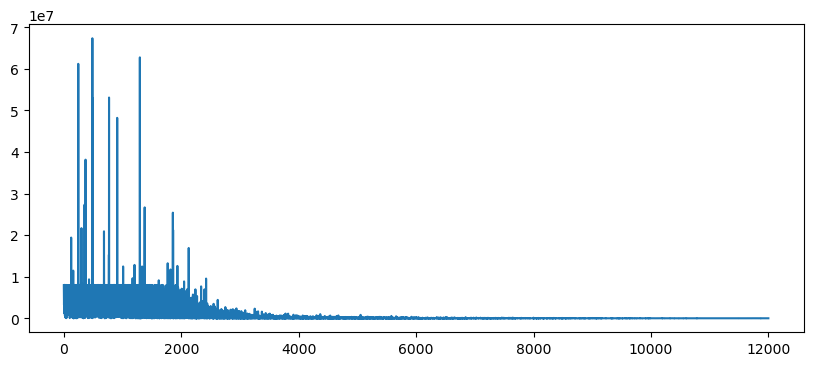

In [15]:
import os
from collections import defaultdict
from functools import partial

import numpy as np
import pyro
import pyro.distributions as dist
import scipy.stats
import torch
import torch.distributions.constraints as constraints
from matplotlib import pyplot
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.poutine import block, replay, trace

# this is for running the notebook in our testing framework
n_steps = 2 if smoke_test else 12000
pyro.set_rng_seed(2)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Sample observations from a Normal distribution with loc 4 and scale 0.1
n = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([0.1]))
data = n.sample((100,))


def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([0.0]))
    pyro.sample("z", dist.Normal(loc_q, scale_q))


def model(data):
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    z = pyro.sample('z', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([0.1])

    with pyro.plate('data', len(data)):
        pyro.sample('x', dist.Normal(z*z, scale), obs=data)


def relbo(model, guide, *args, **kwargs):
    approximation = kwargs.pop('approximation')

    # We first compute the elbo, but record a guide trace for use below.
    traced_guide = trace(guide)
    elbo = pyro.infer.Trace_ELBO(max_plate_nesting=1)
    loss_fn = elbo.differentiable_loss(model, traced_guide, *args, **kwargs)

    # We do not want to update parameters of previously fitted components
    # and thus block all parameters in the approximation apart from z.
    guide_trace = traced_guide.trace
    replayed_approximation = trace(replay(block(approximation, expose=['z']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)

    relbo = -loss_fn - approximation_trace.log_prob_sum()

    # By convention, the negative (R)ELBO is returned.
    return -relbo


def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result


def boosting_bbvi():
    # T=2
    n_iterations = 2
    initial_approximation = partial(guide, index=0)
    components = [initial_approximation]
    weights = torch.tensor([1.])
    wrapped_approximation = partial(approximation, components=components, weights=weights)

    locs = [0]
    scales = [0]

    for t in range(1, n_iterations + 1):

        # Create guide that only takes data as argument
        wrapped_guide = partial(guide, index=t)
        losses = []

        adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
        optimizer = Adam(adam_params)

        # Pass our custom RELBO to SVI as the loss function.
        svi = SVI(model, wrapped_guide, optimizer, loss=relbo)
        for step in range(n_steps):
            # Pass the existing approximation to SVI.
            loss = svi.step(data, approximation=wrapped_approximation)
            losses.append(loss)

            if step % 100 == 0:
                print('.', end=' ')

        # Update the list of approximation components.
        components.append(wrapped_guide)

        # Set new mixture weight.
        new_weight = 2 / (t + 1)

        # In this specific case, we set the mixture weight of the second component to 0.5.
        if t == 2:
            new_weight = 0.5
        weights = weights * (1-new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))

        # Update the approximation
        wrapped_approximation = partial(approximation, components=components, weights=weights)

        print('Parameters of component {}:'.format(t))
        scale = pyro.param("scale_{}".format(t)).item()
        scales.append(scale)
        loc = pyro.param("loc_{}".format(t)).item()
        locs.append(loc)
        print('loc = {}'.format(loc))
        print('scale = {}'.format(scale))


    # Plot the resulting approximation
    X = np.arange(-10, 10, 0.1)
    pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    total_approximation = np.zeros(X.shape)
    for i in range(1, n_iterations + 1):
        Y = weights[i].item() * scipy.stats.norm.pdf((X - locs[i]) / scales[i])
        pyplot.plot(X, Y)
        total_approximation += Y
    pyplot.plot(X, total_approximation)
    pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
    pyplot.title('Approximation of posterior over z')
    pyplot.ylabel('probability density')
    pyplot.show()

    pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    pyplot.plot(losses)
    pyplot.show()
if __name__ == '__main__':
    boosting_bbvi()